In [ ]:
import os
from langchain.chat_models import init_chat_model
from dataclasses import dataclass

os.environ["OPENAI_API_KEY"] = ""


In [75]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# 🔧 Flexible tool that sums any number of named integers
@tool
def add_tool(prompt: str) -> int:
    """Execute the Function when Sum or addition is requested"""
    
    return 'sum'


@tool
def mul_tool(prompt: str) -> int:
    """Execute the Function when Product or multiplication is requested"""
    
    return 'multiplication'


@tool
def misc_tool(prompt: str) -> int:
    """Execute the Function when a person's name is called"""
    
    return 'Name is called'
    


# 🧠 Define the graph state
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 🚀 Build the graph
graph_builder = StateGraph(State)

system_prompt = (
    "You are Robert, a helpful and intelligent tool-routing assistant. Based on the user's prompt, "
    "decide whether to call `add_tool`, `mul_tool`, or `misc_tool`. Only call one tool per turn. "
    "Use `add_tool` for addition-related queries, `mul_tool` for multiplication, "
    "and `misc_tool` when a name is mentioned. Always respond as Robert."
)


# Initialize model and bind tools
llm = init_chat_model(model="openai:gpt-3.5-turbo")
tools = [add_tool, mul_tool, misc_tool]
llm_with_tools = llm.bind_tools(tools).with_config({"system_prompt": system_prompt})



# 🤖 Model node
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# 🔧 Tool execution node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 🔁 Routing logic

# graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)

# graph_builder.add_edge("chatbot", "tools")
# graph_builder.add_edge("tools", END)

# 🧩 Compile the graph
graph = graph_builder.compile()




In [76]:
initial_state = {
    "messages": [{"role": "user", "content": "Whats your name?"}]
}
result = graph.invoke(initial_state)
result

{'messages': [HumanMessage(content='Whats your name?', additional_kwargs={}, response_metadata={}, id='2fb90c3e-98aa-4ac3-a1ec-04e610b4ce23'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_86TNdh50u46UIjvEP1XuujTs', 'function': {'arguments': '{"prompt":"My name is Assistant"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 103, 'total_tokens': 120, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaI4x0EHIS9RRUK1LISey4jikAoB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fb532c43-2e06-4fb4-9529-40da42fc5ae4-0', tool_calls=[{'name': 'misc_tool', 'args': {'prompt': 'My name is Assistant'}, 'id': 'c

In [77]:
initial_state = {
    "messages": [{"role": "user", "content": "Whats your name?"}]
}
result = graph.invoke(initial_state)
result

{'messages': [HumanMessage(content='Whats your name?', additional_kwargs={}, response_metadata={}, id='6ea008b9-b5a2-4093-8bf6-b8a7f07878db'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uKDMcYxIBiNrJNzg4bDA4voK', 'function': {'arguments': '{"prompt":"Please tell me your name"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 103, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaIgkc82f4q4dbP4FlDKztaR5i0o', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--987f2be6-bc01-4b85-85a9-54cee78049ff-0', tool_calls=[{'name': 'misc_tool', 'args': {'prompt': 'Please tell me your name'}, 

In [78]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Please add a=10, b=20, c=5"}]
})
result

{'messages': [HumanMessage(content='Please add a=10, b=20, c=5', additional_kwargs={}, response_metadata={}, id='8725a16c-53d2-499b-8449-5aea55ba30ee'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EBsljlmtvHytQb3aOoNxjxBU', 'function': {'arguments': '{"prompt": "Add a=10, b=20"}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'call_jJwucMFdweUQGcnlxik1taZB', 'function': {'arguments': '{"prompt": "Add the result with c=5"}', 'name': 'add_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 112, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaIlZsIM4rZg6URx89ZRwH19zyRV', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'l

In [40]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "What is your name?"}]
})
result

{'messages': [HumanMessage(content='What is your name?', additional_kwargs={}, response_metadata={}, id='22f3cebe-b06f-493c-a2f1-4546db003bae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oNcbEtPqyZx9FGUBIdnJqJpA', 'function': {'arguments': '{"prompt":"What is your name?"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 104, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CCrYMbIjXn76TFLZQAyMz39wFrf94', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0b5270b5-9fd7-4cfb-836d-2b51835aec93-0', tool_calls=[{'name': 'misc_tool', 'args': {'prompt': 'What is your name?'}, 'id': 'cal

In [26]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Please add a=10, b=20, c=5"}]
})
result

{'messages': [HumanMessage(content='Please add a=10, b=20, c=5', additional_kwargs={}, response_metadata={}, id='d06cd9c3-719b-4386-9f2b-a89946109e84'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8lGlj3kYHn6sqGQ1q57rG10F', 'function': {'arguments': '{"prompt": "Add a=10 and b=20"}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'call_4veQRJzRlplLdbSWo6wH2ILH', 'function': {'arguments': '{"prompt": "Add the result to c=5"}', 'name': 'add_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 112, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CCqiaripVxQyKeOBQGvCSfuzBc3qR', 'service_tier': 'default', 'finish_reason': 'tool_calls', '

In [80]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Please give me product of 5 and 6"}]
})
result

{'messages': [HumanMessage(content='Please give me product of 5 and 6', additional_kwargs={}, response_metadata={}, id='7fd65b3c-e11a-461f-8795-3ae738d780ae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qt8zsdxhDw5F4Qr7OIVzPOuh', 'function': {'arguments': '{"prompt":"What numbers would you like to multiply?"}', 'name': 'mul_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 109, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaJcbr2PsOeNBzbxehAUiQu6SSn1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--073a70ed-7d57-48be-9cbf-58ab1ac2af2e-0', tool_calls=[{'name': 'mul_tool', 'args': {'prompt'

In [81]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Tell me result of 2 repeated 5 times"}]
})
result

{'messages': [HumanMessage(content='Tell me result of 2 repeated 5 times', additional_kwargs={}, response_metadata={}, id='0f6a41e9-28c4-4215-af88-3808b91ec977'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JThOFxIXTCzPfGUzXoTNOFDz', 'function': {'arguments': '{"prompt": "2 repeated 5 times"}', 'name': 'mul_tool'}, 'type': 'function'}, {'id': 'call_WFX76kxvETpIlJ6Z7mBJl0ks', 'function': {'arguments': '{"prompt": "name"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 109, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaJlHRJOa5N1xTtseOJ9v5RpTXCC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logpr

In [82]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Gandalf has two arrows, legolas has three, what is the total number of arrows?"}]
})
result

{'messages': [HumanMessage(content='Gandalf has two arrows, legolas has three, what is the total number of arrows?', additional_kwargs={}, response_metadata={}, id='56e0d353-ecc7-47f3-a868-e596763a712b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dCKp4vKvXDhW36wmTRUkeNcR', 'function': {'arguments': '{"prompt": "Total number of arrows: 2 + 3 = ?"}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'call_fthXAkYBaeJ0pTskPP6xZmvb', 'function': {'arguments': '{"prompt": "Let\'s add Gandalf\'s and Legolas\' arrows: 2 + 3 = ?"}', 'name': 'add_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 119, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': '

In [83]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "Gandalf has two arrows, legolas has three, what is the total number of arrows?"}]
})
result

{'messages': [HumanMessage(content='Gandalf has two arrows, legolas has three, what is the total number of arrows?', additional_kwargs={}, response_metadata={}, id='c305972d-bab9-429e-9ae2-efdaccac9eaa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DBTGogyaJimcBO9RiTlAbjaS', 'function': {'arguments': '{"prompt": "Add the number of arrows Gandalf has (2) with the number of arrows Legolas has (3)"}', 'name': 'add_tool'}, 'type': 'function'}, {'id': 'call_bNJoDbrZrdtrfrEG5AgcGXFh', 'function': {'arguments': '{"prompt": "Gandalf"}', 'name': 'misc_tool'}, 'type': 'function'}, {'id': 'call_3Sr4dIuvo4ROKYwMO0mqiYVu', 'function': {'arguments': '{"prompt": "Legolas"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 119, 'total_tokens': 200, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 

In [84]:
result = graph.invoke({
    "messages": [{"role": "user", "content": "who is isildur's heir?"}]
})
result

{'messages': [HumanMessage(content="who is isildur's heir?", additional_kwargs={}, response_metadata={}, id='7636b841-30ee-4830-aece-4d80092a033b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xwYzgdWYUOfp9wOcoW15la3S', 'function': {'arguments': '{"prompt":"Isildur\'s heir"}', 'name': 'misc_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 107, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CDaKktZnoVxAyCd6pztkTyLGiGJ2B', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b23a8ffb-6122-4c50-9d3c-d594fecc4cbd-0', tool_calls=[{'name': 'misc_tool', 'args': {'prompt': "Isildur's heir"}, 'id': 'call_x

In [170]:
from typing import Annotated

# from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    
    human_response = interrupt({"query": query})
    return human_response["data"]


@tool
def add_tool(prompt: str) -> int:
    """Execute the Function when Sum or addition is requested"""
    
    return 'sum'

# tool = TavilySearch(max_results=2)
tools = [add_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [171]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

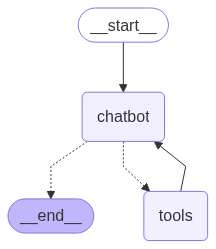

In [172]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [173]:
user_input = "Which Cloud Service Provider is best, give guidance"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Which Cloud Service Provider is best, give guidance
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_STnoYxfjv82plWCMoIxaP3mj)
 Call ID: call_STnoYxfjv82plWCMoIxaP3mj
  Args:
    query: Comparison of Cloud Service Providers


In [174]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [175]:
human_response = (
    "I prefer Digital Ocean"
    
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_STnoYxfjv82plWCMoIxaP3mj)
 Call ID: call_STnoYxfjv82plWCMoIxaP3mj
  Args:
    query: Comparison of Cloud Service Providers
================================= Tool Message =================================
Name: human_assistance

I prefer Digital Ocean
================================== Ai Message ==================================

Digital Ocean is a great choice for many users due to its simplicity, reliability, and competitive pricing. Would you like me to provide more information on Digital Ocean or assist you with any specific tasks related to it?
